In [1]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import copy
import scipy
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat as loadmat
%matplotlib inline

# P1 -- all written, no work to be done in ipython notebook

# P2 -- all written, no work to be done in ipython notebook

# P3 -- all written, no work to be done in ipython notebook

# P4(a)(b)(c) Kalman Filter, Kalman Smoother, and EM algorithms 
In this section, you will implement KF, Kalman smoother and EM algorithm in the kf_smooth function. For each part, you need to test on 4 data-sets.


In [56]:
def kf_smooth(y, A, B, C, d, u, Q, R, init_x, init_V):
    '''
    function xfilt, xpred, Vfilt, loglik, xsmooth, Vsmooth, Q, R = 
               kf_smooth(y, A, B, C, d, u, Q, R, init_x, init_V)


    Kalman filter
    xfilt, xpred, Vfilt, _, _, _, _, _ = kf_smooth(y_all, A, B, C, d, Q, R, init_x, init_V);

    Kalman filter with Smoother
    xfilt, xpred, Vfilt, loglik, xsmooth, Vsmooth, _, _ = kf_smooth(y_all, A, B, C, d, Q, R, init_x, init_V);

    Kalman filter with Smoother and EM algorithm
    xfilt, xpred, Vfilt, loglik, xsmooth, Vsmooth, Q, R = kf_smooth(y_all, A, B, C, d, Q, R, init_x, init_V);

    INPUTS:
    y - observations
    A, B, C, d:  x(:,t+1) = A x(:,t) + B u(:,t) + w(:,t) 
                 y(:,t)   = C x(:,t) + d        + v(:,t)
    Q - covariance matrix of system x(t+1)=A*x(t)+w(t) , w(t)~N(0,Q)
    R - covariance matrix of output y(t)=C*x(t)+v(t) , v(t)~N(0,R)
    init_x - initial mean
    init_V - initial time


    OUTPUTS:
    xfilt = E[X_t|t]
    xpred - the filtered values at time t before measurement
    Vfilt - Cov[X_t|0:t]
    loglik - loglikelihood
    xsmooth - E[X_t|0:T]
    Vsmooth - Cov[X_t|0:T]
    Q - estimated system covariance according to 1 M step (of EM)
    R - estimated output covariance according to 1 M step (of EM)

    '''

    T = y.shape[1]
    ss = Q.shape[0] # size of state space

    #Forward pass (Filter)
    #init the first values

    error_y = np.zeros([y.shape[0], 1, T])
    xpred = np.zeros([init_x.shape[0], init_x.shape[1], T])
    xfilt = np.zeros_like(xpred)
    Vpred = np.zeros([init_V.shape[0], init_V.shape[1], T])
    Vfilt = np.zeros_like(Vpred)

    for t in range(-1, T-1):
        # dynamics update
        # P4(a) Filter
        if t == -1:               # handle the first step separately
            xpred[:, :, t+1] = init_x
            Vpred[:, :, t+1] = init_V
            loglik = 0
        else:
            '''Your code for P4(a) Kalman Filter '''
            # Hint: try something like u[:, t][..., np.newaxis] to fix shape issue
            xpred[:, :, t+1] =  A@xfilt[:,:,t] + B@u[:,t,np.newaxis]
            Vpred[:, :, t+1] =  A@Vfilt[:,:,t]@A.T + Q
            '''Your code end'''
            
        '''Your code for P4(a) Kalman Filter '''
        # Hint: you should follow the slides to compute xfilt and Vfilt
        error_y[:, :, t+1] =  y[:,t+1, np.newaxis] - (C@xpred[:,:,t+1]+d)# error (innovation)
        
        S = C@Vpred[:,:,t+1]@C.T+R# # Innovation (or residual) covariance: C Vpred_{t+1} C^T + R, you can ignore this temp var and write your own!
        K = Vpred[:,:,t+1]@C.T@np.linalg.inv(S)  # Kalman gain matrix
        
        xfilt[:, :, t+1] = xpred[:,:,t+1] + K@error_y[:, :, t+1]
        Vfilt[:, :, t+1] = (np.eye(ss) - K@C)@Vpred[:,:,t+1]
        '''Your code end'''
        
        '''Your code for P4(b)(c) Kalman Smoother and EM '''
        # Hint: compute loglikelihood, note it is gaussian
        Sigma = S
        dd = error_y.shape[0] # dimensions
        denom = ((2*np.pi)**(dd)*np.linalg.det(Sigma))**0.5
        # Hint: denom is used at the end of the next line. :)
        loglik = loglik + ( -1/2*error_y[:, :, t+1].T @ np.linalg.pinv(Sigma) @ error_y[:, :, t+1] + np.log(1/denom))
        '''Your code end'''
    # Backward pass (RTS Smoother and EM algorithm)
    # init the last values
    xsmooth = np.zeros_like(xfilt)
    Vsmooth = np.zeros_like(Vfilt)
    xsmooth[:, :, T-1] = xfilt[:, :, T-1]
    Vsmooth[:, :, T-1] = Vfilt[:, :, T-1]
    L = np.zeros_like(Vfilt)
    Q=Q * 0
    R=R * 0
    for t in range(T-1, -1, -1):
        if t < T-1:
            '''Your code for P4(b) Kalman Smoother '''
            # Hint: P4(b) Smoother 
            L[:,:,t] =  Vfilt[:, :, t]@A.T@np.linalg.inv(Vpred[:, :, t+1])# smoother gain matrix
            xsmooth[:, :, t] = xfilt[:, :, t] + L[:, :, t]@(xsmooth[:, :, t+1] - xpred[:, :, t+1])
            Vsmooth[:, :, t] = Vfilt[:, :, t] + L[:, :, t]@(Vsmooth[:, :, t+1] - Vpred[:, :, t+1])@L[:, :, t].T
            '''Your code end'''

            '''Your code for P4(c) the EM algorithm '''
            # P4(c) EM algorithm
            error_x = xsmooth[:, :, t+1] - (A@xsmooth[:, :, t] + B@u[:, t, np.newaxis])
            P =  Vsmooth[:, :, t+1] - Vsmooth[:, :, t+1] @ L[:, :, t].T @ A.T - A @ L[:, :, t] @ Vsmooth[:, :, t+1]
            Q = Q + error_x @ error_x.T + A @ Vsmooth[:, :, t] @ A.T + P
            e_y = y[:, t][:, np.newaxis] - (C @ xsmooth[:, :, t] + d)
            R = R + e_y @ e_y.T + C @ Vsmooth[:, :, t] @ C.T
            '''Your code end'''
    Q = Q / (T-1)
    R = R / T

    return xfilt, xpred, Vfilt, loglik, xsmooth, Vsmooth, Q, R

In [4]:
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
# how I generate the data
# x_start = np.array([[0.1000],    [0.2000],    [0.3000],   [0.4000],   [-0.5000]])  # some number
# T = 500

# nX = A.shape[0]
# nZ = C.shape[0]
# nU = B.shape[1]

# Sigma_w = Q
# Sigma_v = R

# w = np.random.randn(nX,T)
# w = scipy.linalg.sqrtm(Sigma_w) @ w
# v = np.random.randn(nZ,T)
# v = scipy.linalg.sqrtm(Sigma_v) @ v

# u = np.random.randn(nU, T );
# # import pdb; pdb.set_trace()
# y[:,0] = np.squeeze(C @ x_start + d + v[:,0][..., np.newaxis])

# for t in range(T-1):
#     x[:,t+1] = np.squeeze(A @ x[:,t][..., np.newaxis] + B @ u[:,t][..., np.newaxis] + w[:,t][..., np.newaxis])
#     y[:,t+1] = np.squeeze(C @ x[:,t+1][..., np.newaxis] + d + v[:,t+1][..., np.newaxis])
# np.save('p3_a_data_1.npy', [T, A, B, C, d, u, y, x])

# P4 (a) test
Let's test our algorithms! The two figures should be generated with the following code:

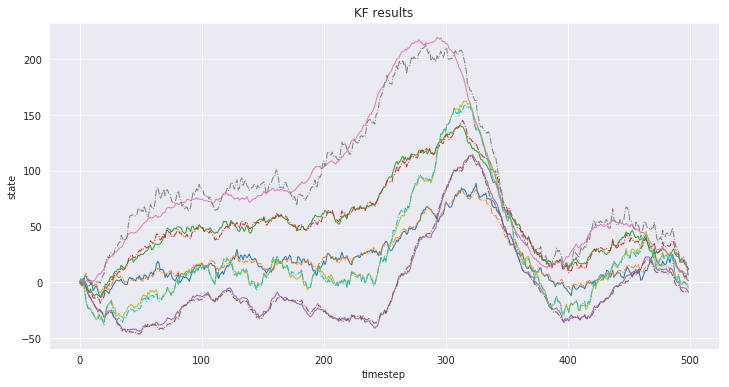

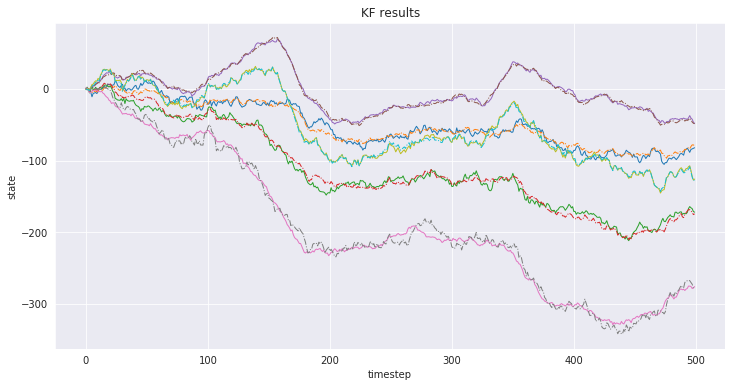

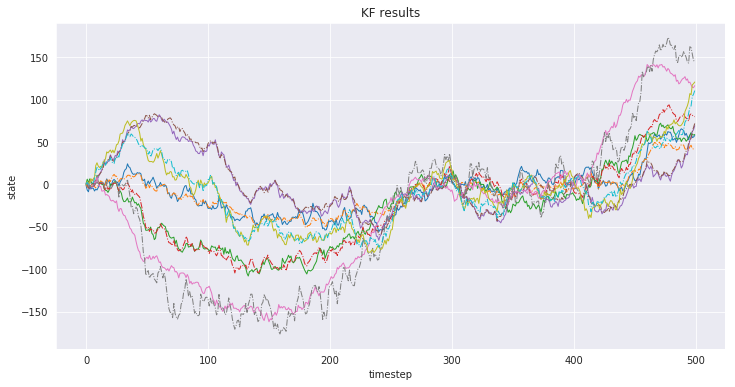

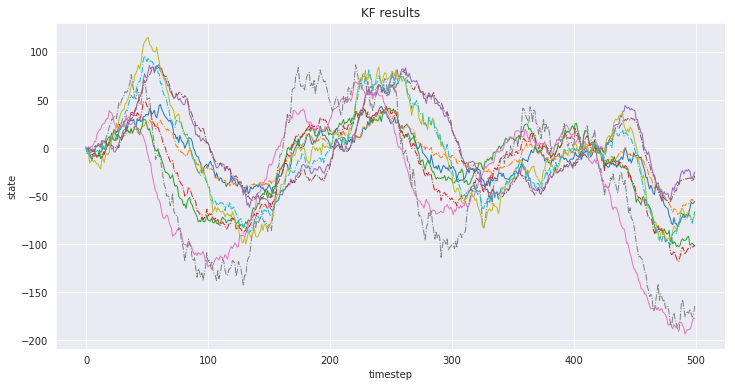

In [6]:


""" When P4 (a) Kalman Filtering is done, please run this:  """
for index in range(4):
    # data generation, whenever you want to run P4 (a)(b)(c), run this first!
    T, A, B, C, d, u, y, x  = np.load(f'p3_a_data_{index+1}.npy', allow_pickle=True)
    # now you should have variables:
    # T, A, B, C, d, u, y, x 
    # They are described in the kf_smooth function. x is the groundtruth. 

    x_init = np.zeros([5,1]); # mean at time t=1 before measurement at time t=1
    P_init = np.eye(5);     # covariance at time t=1 before measurement at time t=1


    # I found initially overestimating Q and R gives better learning of Q and R
    # during EM

    Q = 10*np.eye(5); R = 10*np.eye(2);
    ll = np.zeros(100)
#     for i in range(100):
    xfilt, xpred, Vfilt, loglik, _, _, _, _ = kf_smooth(y, A, B, C, d, u, Q, R, x_init, P_init)
    
    
    plt.figure(figsize=(12, 6))
    for i in range(5):
        plt.plot(np.squeeze(x)[i, :],linewidth=1)
        plt.plot(np.squeeze(xfilt)[i, :], '-.', linewidth=1)
    plt.xlabel('timestep')
    plt.ylabel('state')
    plt.title('KF results')
    plt.show()



# Please check the result in the plots. Plots for the first two datasets are provided as reference.

# P4 (b) Test
Let's test our algorithms! The two figures should be generated with the following code:

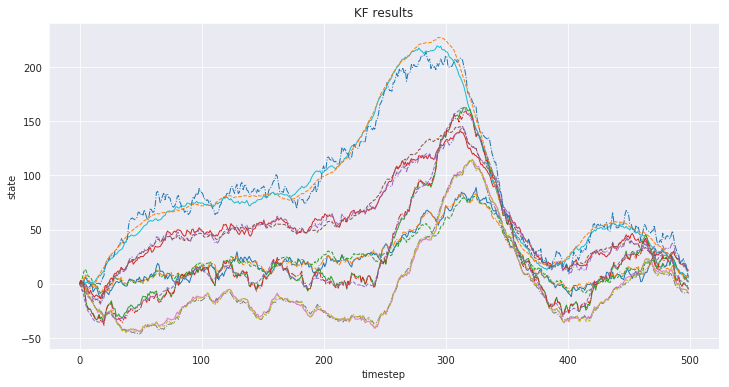

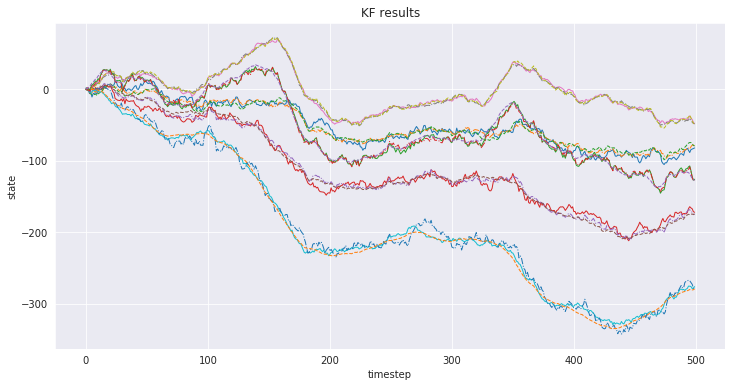

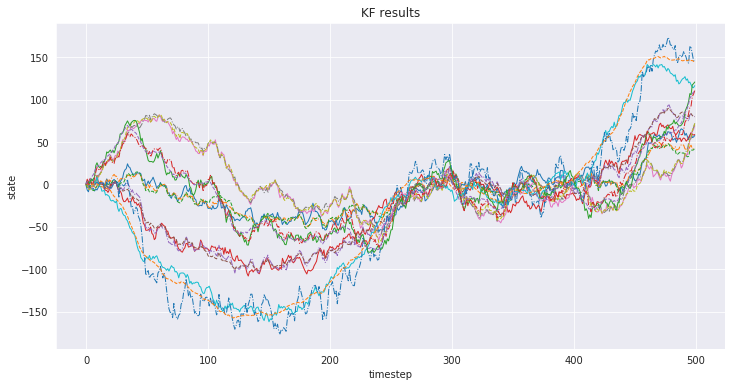

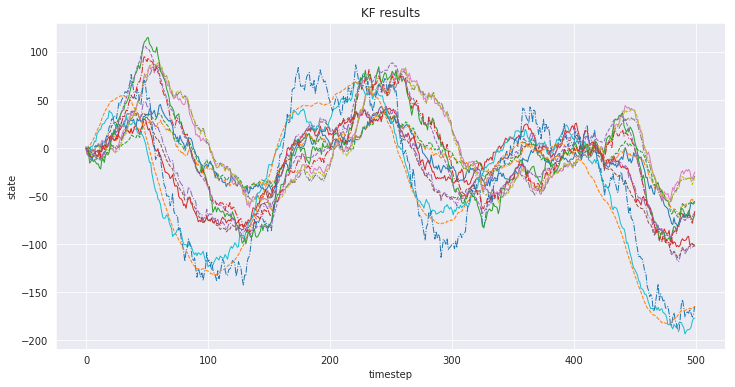

In [7]:
""" When P4 (b) Kalman Filtering is done, please run this:  """
for index in range(4):
    # data generation, whenever you want to run P4 (a)(b)(c), run this first!
    T, A, B, C, d, u, y, x  = np.load(f'p3_a_data_{index+1}.npy', allow_pickle=True)
    # now you should have variables:
    # T, A, B, C, d, u, y, x 
    # They are described in the kf_smooth function. x is the groundtruth. 

    x_init = np.zeros([5,1]); # mean at time t=1 before measurement at time t=1
    P_init = np.eye(5);     # covariance at time t=1 before measurement at time t=1


    # I found initially overestimating Q and R gives better learning of Q and R
    # during EM

    Q = 10*np.eye(5); R = 10*np.eye(2);
    ll = np.zeros(100)

#     for i in range(100):
    xfilt, xpred, Vfilt, loglik, xsmooth, Vsmooth, _, _ = kf_smooth(y, A, B, C, d, u, Q, R, x_init, P_init)
    ll[i] = loglik


    plt.figure(figsize=(12, 6))
    for i in range(5):
        plt.plot(np.squeeze(x)[i, :],linewidth=1)
        plt.plot(np.squeeze(xfilt)[i, :], '-.', linewidth=1)
        plt.plot(np.squeeze(xsmooth)[i, :], '--', linewidth=1)
    plt.xlabel('timestep')
    plt.ylabel('state')
    plt.title('KF results')
    plt.show()

# Compare the Filtering and smoothing, which one is better? (No need to report). 
# Plots for the first two datasets are provided as reference.

# P4 (c) Test
Let's test our algorithms! The two figures should be generated with the following code:

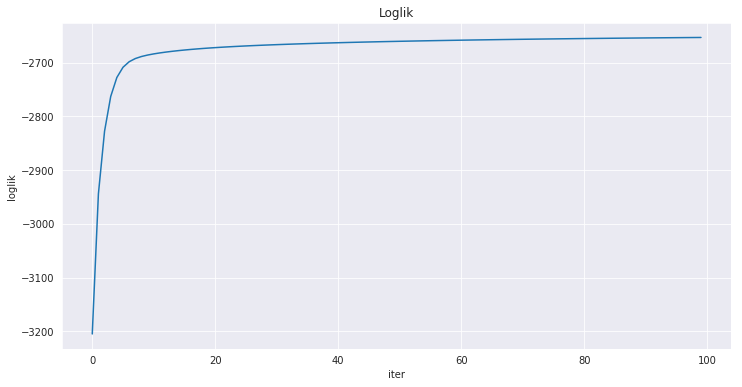

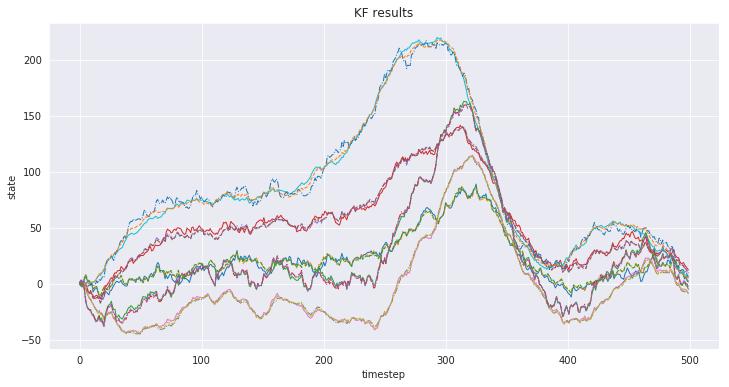

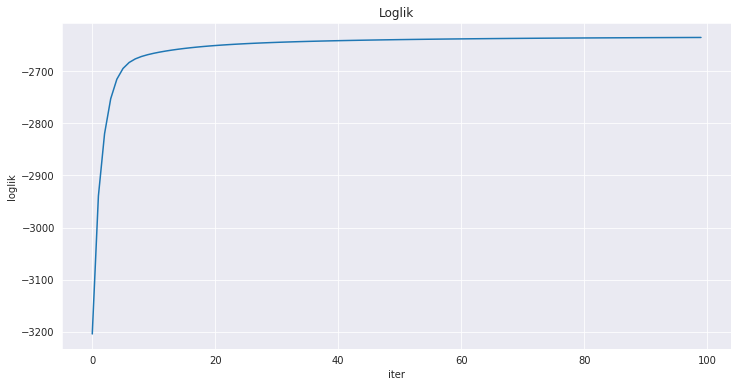

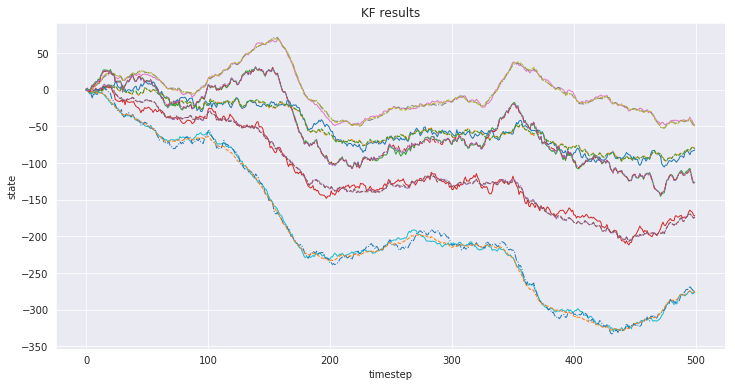

In [12]:
""" When P4 (c) EM is done, please run this:  """
for index in range(4):
    # data generation, whenever you want to run P4 (a)(b)(c), run this first!
    T, A, B, C, d, u, y, x  = np.load(f'p3_a_data_{index+1}.npy', allow_pickle=True)
    # now you should have variables:
    # T, A, B, C, d, u, y, x 
    # They are described in the kf_smooth function. x is the groundtruth. 

    x_init = np.zeros([5,1]); # mean at time t=1 before measurement at time t=1
    P_init = np.eye(5);     # covariance at time t=1 before measurement at time t=1


    # I found initially overestimating Q and R gives better learning of Q and R
    # during EM

    Q = 10*np.eye(5); R = 10*np.eye(2);
    ll = np.zeros(100)

    for i in range(100):
        xfilt, xpred, Vfilt, loglik, xsmooth, Vsmooth, Q, R = kf_smooth(y, A, B, C, d, u, Q, R, x_init, P_init)
        ll[i] = loglik

    if index > 1:
        break
    
    plt.figure(figsize=(12, 6))
    plt.plot(ll)
    plt.xlabel('iter')
    plt.ylabel('loglik')
    plt.title('Loglik')
    plt.show()

    plt.figure(figsize=(12, 6))
    for i in range(5):
        plt.plot(np.squeeze(x)[i, :],linewidth=1)
        plt.plot(np.squeeze(xfilt)[i, :], '-.', linewidth=1)
        plt.plot(np.squeeze(xsmooth)[i, :], '--', linewidth=1)
    plt.xlabel('timestep')
    plt.ylabel('state')
    plt.title('KF results')
    plt.show()

# Hint: Note that loglik should be increasing. 
# Compare the filtering and smoothing results with the previous plots, do you see some difference? (No need to report)
# Plots for the first two datasets are provided as reference.

# P4 (d) Population Estimation
In this section, we will use the KF we just implemented for population estimation applications. Check Problem 4 d in the pdf for detailed quesitons.
Deliverables: A, B, C, d, Q, R matrices and the hours for three species

In [57]:
x0 = np.array([[6], [6], [6]])
P_0 = np.eye(3)*2


# I found initially overestimating Q and R gives better learning of Q and R
# during EM

'''Your code here'''
Q = np.zeros((3,3))
R = np.array([[0.36]])  # make it a 2-D array even it's just one number, such as np.array([[x]])

A = np.diag(np.array([1.02, 1.06, 1.11]))
B = np.zeros((3,1))
C = np.ones((1,3))
d = np.zeros((1,1))
'''Your code end'''

done_with_1 = 0
done_with_2 = 0
done_with_3 = 0


for T in range(20,100):
    if done_with_1 and done_with_2 and done_with_3:
        break

    u = np.zeros([1,T])
    y = np.zeros([1,T])
    xfilt, _, Vfilt, loglik, xsmooth, Vsmooth, _, _ = kf_smooth(y, A, B, C, d, u, Q, R, x0, P_0);

    ''' Your code here '''
#     you need to write the correct condition after each ``if''

    if Vsmooth[0, 0, 0] < 0.01:
        done_with_1 = 1
        print('done with 1')
        print(f'Time for U is {T}')

    if Vsmooth[1, 1, 0] < 0.01:
        done_with_2 = 1
        print('done with 2')
        print(f'Time for V is {T}')

    if Vsmooth[2, 2, 0] < 0.01:
        done_with_3 = 1
        print('done with 3')
        print(f'Time for V is {T}')
    ''' Your code end '''



done with 3
Time for V is 32
done with 3
Time for V is 33
done with 3
Time for V is 34
done with 3
Time for V is 35
done with 3
Time for V is 36
done with 3
Time for V is 37
done with 3
Time for V is 38
done with 3
Time for V is 39
done with 3
Time for V is 40
done with 3
Time for V is 41
done with 3
Time for V is 42
done with 3
Time for V is 43
done with 3
Time for V is 44
done with 3
Time for V is 45
done with 3
Time for V is 46
done with 3
Time for V is 47
done with 3
Time for V is 48
done with 3
Time for V is 49
done with 3
Time for V is 50
done with 3
Time for V is 51
done with 3
Time for V is 52
done with 3
Time for V is 53
done with 2
Time for V is 54
done with 3
Time for V is 54
done with 2
Time for V is 55
done with 3
Time for V is 55
done with 2
Time for V is 56
done with 3
Time for V is 56
done with 2
Time for V is 57
done with 3
Time for V is 57
done with 2
Time for V is 58
done with 3
Time for V is 58
done with 2
Time for V is 59
done with 3
Time for V is 59
done with 2
Ti

# P4 (e) -- all written, no work to be done in ipython notebook

# Part 3: P5 Sensor Selection
In this section, we will implement the sensor selection algorithm as described in the pdf. 
Deliverables: 3 figures: (1) same sensor (2) round robin (3) greedy selection

We will use a time_and_meas_update function for computing Sigma:

In [60]:
def time_and_meas_update(Sigma, A, Sigma_w, C, R):
    '''Your code here'''
    # all the definitions are similar to KF implementation, performing time update and measurement update
    # here Sigma_w is Q in the slides. You need to output the Sigma for the measurement update.
    n = A.shape[0]
    Sigma_new = Sigma # this line is given
    Sigma_new = A@Sigma_new@A.T + Sigma_w
    S = C@Sigma_new@C.T + R
    K = Sigma_new@C.T@np.linalg.inv(S)
    Sigma_new = (np.eye(n) - K@C)@Sigma_new
    '''your code end'''
    return Sigma_new
    

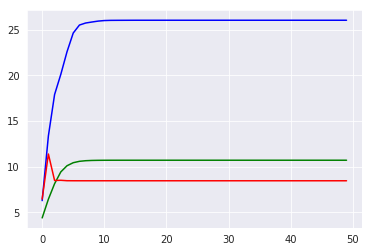

In [61]:
# initialize the three sensors
n=3
A  = np.array([[-0.6, 0.8, 0.5], [-0.1, 1.5, -1.1], [1.1, 0.4, -0.2]])
Sigma_w = np.eye(n)
S1 = np.array([[0.74, -0.21, -0.64]])
S2 = np.array([[0.37, 0.86, 0.37]])
S3 = np.array([[0, 0, 1]])
Sigma_S1 = np.array([[0.1**2]])
Sigma_S2 = np.array([[0.1**2]])
Sigma_S3 = np.array([[0.1**2]])

Sigma_0 = np.eye(n)

T = 50
s1_trace = []
s2_trace = []
s3_trace = []

# same sensor version code provided as an example
Sigma = Sigma_0
for t in range(T):
    Sigma = time_and_meas_update(Sigma, A, Sigma_w, S1, Sigma_S1)
    s1_trace.append(np.trace(Sigma))

Sigma = Sigma_0
for t in range(T):
    Sigma = time_and_meas_update(Sigma, A, Sigma_w, S2, Sigma_S2)
    s2_trace.append(np.trace(Sigma))

Sigma = Sigma_0;
for t in range(T):
    Sigma = time_and_meas_update(Sigma, A, Sigma_w, S3, Sigma_S3);
    s3_trace.append(np.trace(Sigma))



plt.figure() 
plt.plot(s1_trace, 'b') 
plt.plot(s2_trace,'g')
plt.plot(s3_trace,'r') 

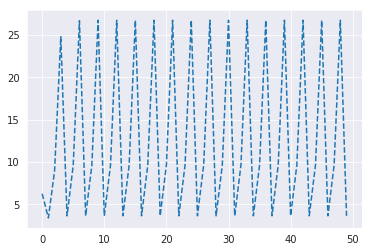

In [62]:
# round-robin starts :

Sigma = Sigma_0
s123_trace = []

for t in range(T):
    '''Your code here'''
    # you need to write the round robin algo to choose which Sigma to use
    # note C is selected from Sigma_S*
    Ss = [S1, S2, S3]
    Rs = [Sigma_S1, Sigma_S2, Sigma_S3]
    C = Ss[t%3]
    R = Rs[t%3]
    '''Your code end'''
    
    Sigma = time_and_meas_update(Sigma, A, Sigma_w, C, R)
    s123_trace.append(np.trace(Sigma))

    
plt.figure() 
plt.plot(s123_trace, '--');

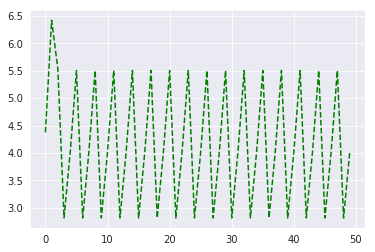

In [63]:
# greedy:

Sigma = Sigma_0
s1_greedy_trace = []
s2_greedy_trace = []
s3_greedy_trace = []
sgreedy_choice = []
sgreedy_trace = []
for t in range(T):
    C=S1
    R=Sigma_S1
    Sigma_try1 = time_and_meas_update(Sigma, A, Sigma_w, C, R)
    s1_greedy_trace.append(np.trace(Sigma_try1))

    C=S2
    R=Sigma_S2
    Sigma_try2 = time_and_meas_update(Sigma, A, Sigma_w, C, R)
    s2_greedy_trace.append(np.trace(Sigma_try2))

    C=S3
    R=Sigma_S3
    Sigma_try3 = time_and_meas_update(Sigma, A, Sigma_w, C, R)
    s3_greedy_trace.append(np.trace(Sigma_try3))
    '''Your code here'''
    # your greedy algorithm
    # select your Sigma based on tries!
    Rs = [Sigma_try1, Sigma_try2, Sigma_try3]
    idx = np.argmin(np.array([np.trace(sigma) for sigma in Rs]))
    Sigma = Rs[idx]
    sgreedy_trace.append(np.trace(Sigma))
    '''Your code end'''
plt.figure()
plt.plot(sgreedy_trace,'g--')

# P6 EKF
In this section, we will play with Extended KF.
Deliverables: 2 figures gnerated by the code, your last step mean and variance.

FIrst we provide a function to computer Jacobian numerically:

In [64]:
# Numerical Jacobian of func 
# idx specifies the index of argument w.r.t which the Jacobian is computed
# the rest are arguments passed to func

# For instance, for y = f(x1, x2, ..., xN)
# numerical_jac(@f, 2, x1, x2, ..., xN) computes the Jacobian df/dx2

def numerical_jac(func, idx, var_list):
    step = 1e-6;

    x = var_list[idx]
    y = func(*var_list)
    lenx = len(x)
    leny = len(y)
    J = np.zeros([leny, lenx])

    for i in range(lenx):
        xhi = x[i] + step
        xlo = x[i] - step

        var_list[idx][i] = xhi
        yhi = func(*var_list)
        var_list[idx][i] = xlo
        ylo = func(*var_list)    
        var_list[idx][i] = x[i]
        J[:,i] = np.squeeze((yhi - ylo)/(xhi - xlo)) 

    return J

The follow code are the main code for EKF:

In [65]:
def ekf(x_t, Sigma_t, u_t, z_tp1, model):
    xDim = model.xDim
    qDim = model.qDim
    rDim = model.rDim
    Q = model.Q
    R = model.R
    '''Your code here:'''
    A = numerical_jac(model.dynamics_func, 0, [x_t, u_t, np.zeros([qDim,1])])
    M = numerical_jac(model.dynamics_func, 2, [x_t, u_t, np.zeros([qDim,1])])
    Sigma_tp1 =  A@Sigma_t@A.T + M@Q@M.T# write your Sigma t plut 1
    x_tp1 = model.dynamics_func(x_t, u_t, np.zeros([qDim,1])) # forward with dynamcis 

    H = numerical_jac(model.obs_func, 0, [x_tp1, np.zeros([rDim,1])])
    N = numerical_jac(model.obs_func, 1, [x_tp1, np.zeros([rDim,1])])

    K = Sigma_tp1@H.T@np.linalg.inv(H@Sigma_tp1@H.T + N@R@N.T)

    x_tp1 = x_tp1 + K @ (z_tp1 - model.obs_func(x_tp1, np.zeros([rDim,1])))
    Sigma_tp1 = (np.eye(xDim) - K @ H) @ Sigma_tp1
    '''Your code end'''
    return x_tp1, Sigma_tp1

In [67]:
def plot_1d_trajectory(mean_ekf, cov_ekf, X, model):

    
    hor = np.array(range(model.T))

    # Iterate over dimensions
    for d in range(model.xDim):
        plt.figure(figsize=(12, 6))
        x_td = np.squeeze(mean_ekf[d, :, :]).T
        Sigma_td = np.squeeze(cov_ekf[d,d,:])

        ff1 = np.hstack([hor,  np.flip(hor)])
        ff2 = np.hstack([(x_td + 3*np.sqrt(Sigma_td)), 
                         np.flip((x_td - 3*np.sqrt(Sigma_td)))])
        plt.fill_between(ff1, ff2, alpha=0.5)
        plt.plot(hor, X[d,:], 'rs-', linewidth=3)   # ground truth
        plt.plot(hor, x_td, 'b*-.', linewidth=1)
        plt.plot(hor, x_td + 3*np.sqrt(Sigma_td), color=np.array([0, 4, 0])/8)
        plt.plot(hor, x_td - 3*np.sqrt(Sigma_td), color=np.array([0, 4, 0])/8)
        plt.xlabel('time steps')
        plt.ylabel('state')
        plt.show()


In [97]:
# This is how I generate data
# X = np.zeros([model.xDim, model.T]) # true states (not known)
# Z = np.zeros([model.zDim, model.T]) # observations received
# X[:, 0] = np.squeeze(x0 + np.linalg.cholesky(Sigma0).T @ np.random.randn(model.xDim,1))
# Z[:, 0] = np.squeeze(model.obs_func(X[:,0], 0.4*np.linalg.cholesky(model.R).T @ np.random.randn(model.rDim,1)))
# T=50
# for t in range(T-1):
#     X[:, t+1] = np.squeeze(model.dynamics_func(X[:,t], np.zeros([model.uDim,1]), 0.4*np.linalg.cholesky(model.Q).T @ np.random.randn(model.qDim,1)))
#     Z[:, t+1] = np.squeeze(model.obs_func(X[:,t+1], np.linalg.cholesky(model.R).T  @ np.random.randn(model.rDim,1)))

# np.save('p6_data_3.npy', [X, Z])

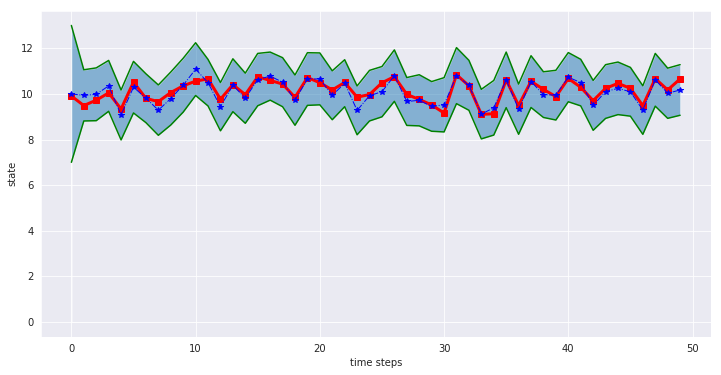

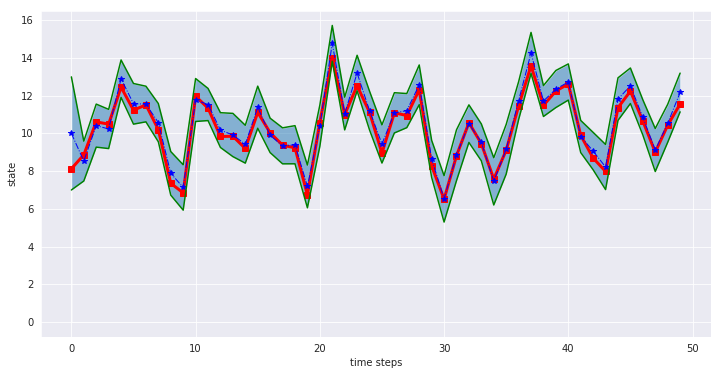

Mean at last timestep: [[10.1720216]
 [12.1714852]]
Covariance matrix at last timestep: [[ 0.13682933 -0.09657053]
 [-0.09657053  0.11717673]]


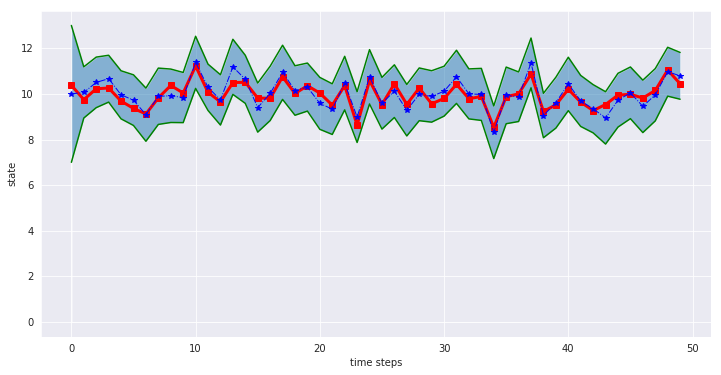

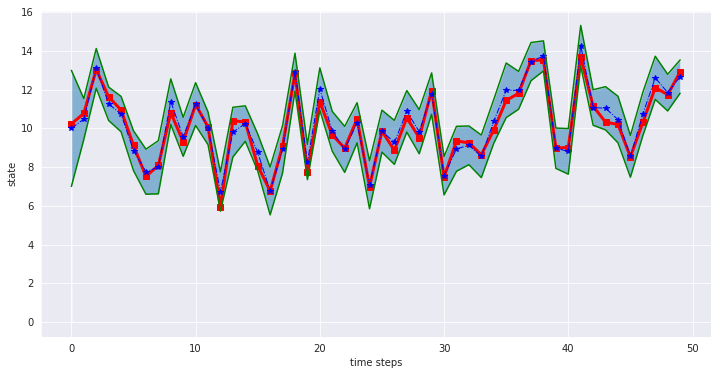

Mean at last timestep: [[10.7912982 ]
 [12.67471737]]
Covariance matrix at last timestep: [[ 0.11673337 -0.07153601]
 [-0.07153601  0.0822951 ]]


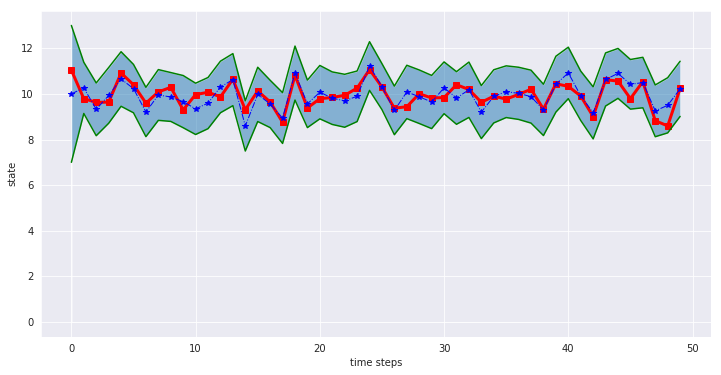

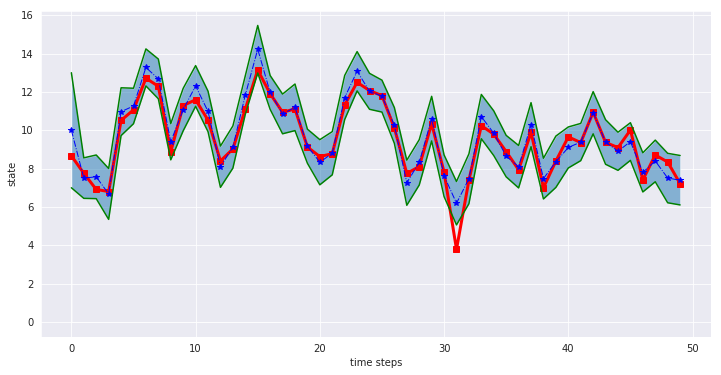

Mean at last timestep: [[10.2210989 ]
 [ 7.39401405]]
Covariance matrix at last timestep: [[ 0.16261977 -0.13872258]
 [-0.13872258  0.18477358]]


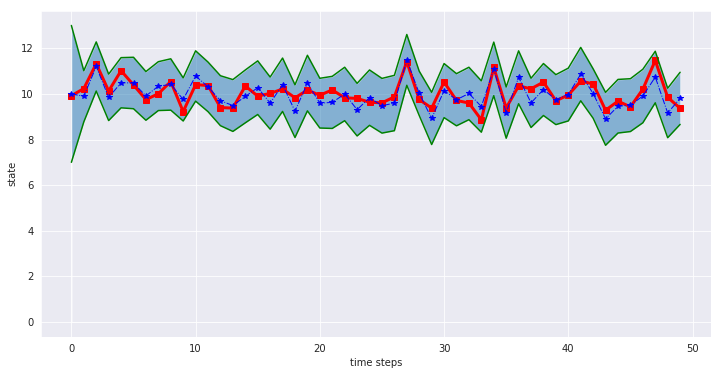

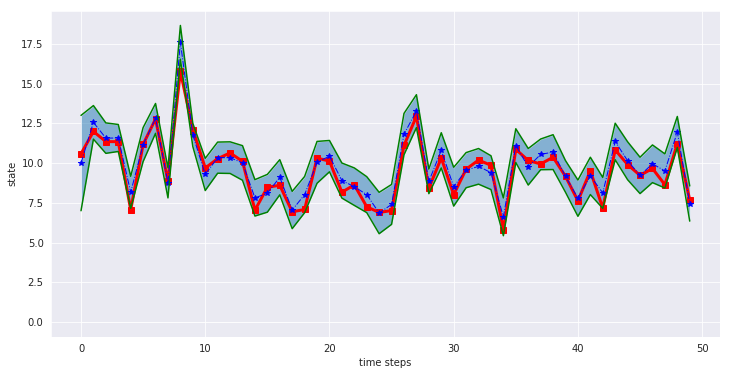

Mean at last timestep: [[9.80437518]
 [7.45398483]]
Covariance matrix at last timestep: [[ 0.14522128 -0.10965416]
 [-0.10965416  0.13643941]]


In [68]:
# test ekf

# Setup model
class Model():
    def __init__(self):
        # Setup model dimensions
        self.xDim = 2 # state space dimension
        self.uDim = 2 # control input dimension
        self.qDim = 2 # dynamics noise dimension
        self.zDim = 2 # observation dimension
        self.rDim = 2 # observation noise dimension
        self.Q = 2*np.eye(self.qDim) # dynamics noise variance
        self.R = np.eye(self.rDim) # observation noise variance
        self.R[1,1] = 10
        self.T = 50 # number of time steps in trajectory
    
   
    # Dynamics function: x_t+1 = dynamics_func(x_t, u_t, q_t, model)
    def dynamics_func(self, x_t, u_t, q_t):
        x_tp1 = np.zeros([self.xDim,1])
        x_tp1[0] = 0.1*(x_t[0]*x_t[0]) - 2*x_t[0] + 20 + q_t[0]
        x_tp1[1] = x_t[0] + 0.3*x_t[1] - 3 + q_t[1]*3
        return x_tp1

    # Observation function: z_t = obs_func(x_t, r_t, model)
    def obs_func(self, x_t, r_t):
        z_t = np.zeros([self.zDim, 1])
        z_t[0] = (x_t.T @ x_t) + np.sin(5*r_t[0])
        z_t[1] = 3*(x_t[1]*x_t[1])/x_t[0] + r_t[1]
        return z_t
                    
    def load_states_observations(self, i):
        X, Z = np.load(f'p6_data_{i}.npy', allow_pickle=True)
        return X, Z

model = Model()

x0 = np.array([[10], [10]])
Sigma0 = np.eye(model.xDim)
for index in range(4):
    X, Z = model.load_states_observations(index)

    # Mean and covariances for plotting
    mean_ekf = np.zeros([model.xDim, 1, model.T])
    cov_ekf =  np.zeros([model.xDim, model.xDim, model.T])

    mean_ekf[:, :, 0] = x0
    cov_ekf[:, :, 0] = Sigma0

    for t in range(model.T-1):
        mean_ekf[:, :, t+1], cov_ekf[:, :, t+1] = ekf(mean_ekf[:,:,t], cov_ekf[:,:,t], np.zeros([model.uDim,1]), Z[:,t+1][..., np.newaxis], model)
    
    
    plot_1d_trajectory(mean_ekf, cov_ekf, X, model)


    print(f'Mean at last timestep: {mean_ekf[:, :, model.T-1]}')
    print(f'Covariance matrix at last timestep: {cov_ekf[:, :, model.T-1]}')

# The plot for the initial two data-sets are provided as reference.
